In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

import pandas as pd
import numpy as np

from networks.nonlinearnet_aihuman import NonLinearNetDefer
#from helpers.utils import fingerprints_from_mol

#from rdkit import Chem

#from tdc import Oracle

from matplotlib import pyplot as plt

In [5]:
oracle = Oracle(name = 'DRD2')

Found local copy...


In [6]:
model = NonLinearNetDefer(2048, 0.2)

### L2D - No active learning

In [8]:
seed = 1
n_rounds = 6
directory_base = f"/home/klgx638/Projects/Reinvent_humanAI_reward/reinvent_runs/l2d-hitl-demo2_Tanimoto_noise0.0_K{n_rounds}_None_seed{seed}"
acquisition = "None"

mean_pred_score_by_round = []
mean_oracle_score_by_round = []
deferrals = []
idx_of_deferred_base = []
scaffs_base = []

model.load_state_dict(torch.load("models/l2d_model_demo2.pt", map_location="cpu"))

for k in range(n_rounds):
    if k == 0:
        scaff = pd.read_csv(os.path.join(directory_base, "results/scaffold_memory.csv"))
        scaffs_base.append(scaff)
    else:
        scaff = pd.read_csv(os.path.join(directory_base, f"iteration{k}_{acquisition}/results/scaffold_memory.csv"))
        scaffs_base.append(scaff)
    scaff = scaff.sort_values(by=["raw_bioactivity"], ascending=False)
    fps = fingerprints_from_mol([Chem.MolFromSmiles(s) for s in scaff.SMILES.tolist()])
    preds, decision_outs = model(torch.tensor(fps, dtype=torch.float32))
    boolean = (
        (decision_outs[:, 0] > preds[:, 0])
        * (
            (preds[:, 0] > 0.5)
            * (preds[:, 1] > preds[:, 0])
            + (preds[:, 0] < 0.5)
            * (preds[:, 1] < preds[:, 0])
        )
    ).float()
    deferrals.append(boolean.mean().item())
    idx_of_deferred_base.append(np.where(boolean==1))
    
    mean_pred_score_by_round.append(np.mean(scaff.raw_bioactivity))
    mean_oracle_score_by_round.append(np.mean([oracle(s) for s in scaff.SMILES.tolist()]))

0.003713330952450633
0.0010733801173046231
0.0010129846632480621
0.0002650176757015288
0.0007077140617184341
0.0001718803687253967


### L2D - active learning

In [9]:
acquisition = "uncertainty"
directory_al = f"/home/klgx638/Projects/Reinvent_humanAI_reward/reinvent_runs/l2d-hitl-demo2_Tanimoto_noise0.0_K{n_rounds}_{acquisition}_T5_n10_seed{seed}"

mean_pred_score_by_round_greedy = []
mean_oracle_score_by_round_greedy = []
deferrals_al = []
idx_of_deferred_al = []
scaffs = []

for k in range(n_rounds):
    model = NonLinearNetDefer(2048, 0.2)
    if k == 0:
        scaff = pd.read_csv(os.path.join(directory_base, "results/scaffold_memory.csv"))
        model.load_state_dict(torch.load("models/l2d_model_demo2.pt", map_location="cpu"))
        scaffs.append(scaff)
    if k > 0: 
        scaff = pd.read_csv(os.path.join(directory_al, f"iteration{k}_{acquisition}/results/scaffold_memory.csv"))
        scaffs.append(scaff)
        if k == 1:
            model.load_state_dict(torch.load(os.path.join(directory_al, f"l2d_model_demo2_iteration_{k}.pt"), map_location="cpu"))
        else:
            model.load_state_dict(torch.load(os.path.join(directory_al, f"iteration{k-1}_{acquisition}/l2d_model_demo2_iteration_{k}.pt"), map_location="cpu"))
    scaff = scaff.sort_values(by=["raw_bioactivity"], ascending=False)
    fps = fingerprints_from_mol([Chem.MolFromSmiles(s) for s in scaff.SMILES.tolist()])
    preds, decision_outs = model(torch.tensor(fps, dtype=torch.float32))
    boolean = (
        (decision_outs[:, 0] > preds[:, 0])
        * (
            (preds[:, 0] > 0.5)
            * (preds[:, 1] > preds[:, 0])
            + (preds[:, 0] < 0.5)
            * (preds[:, 1] < preds[:, 0])
        )
    ).float()
    deferrals_al.append(boolean.mean().item())
    idx_of_deferred_al.append(np.where(boolean==1))
    
    mean_pred_score_by_round_greedy.append(np.mean(scaff.raw_bioactivity))
    mean_oracle_score_by_round_greedy.append(np.mean([oracle(s) for s in scaff.SMILES.tolist()]))

0.0035276643466204405
0.00255955895408988
0.0036727574188262224
0.004057709593325853
0.0034855662379413843
0.0023976555094122887


## Draw molecules

In [64]:
#model.load_state_dict(torch.load("models/l2d_model_demo2.pt", map_location="cpu"))
model.load_state_dict(torch.load(os.path.join(directory_al, f"iteration5_uncertainty/l2d_model_demo2_iteration_6.pt"), map_location="cpu"))
model.eval()
sample = scaffs[-1].iloc[idx_of_deferred_al[-1]].sample(8)
fps = fingerprints_from_mol([Chem.MolFromSmiles(s) for s in sample.SMILES.tolist()])
pred, _ = model(torch.tensor(fps, dtype=torch.float32))
sample["classifier_score"] = pred[:,0].detach().numpy()
sample["oracle_score"] = [oracle(s) for s in sample.SMILES.tolist()]

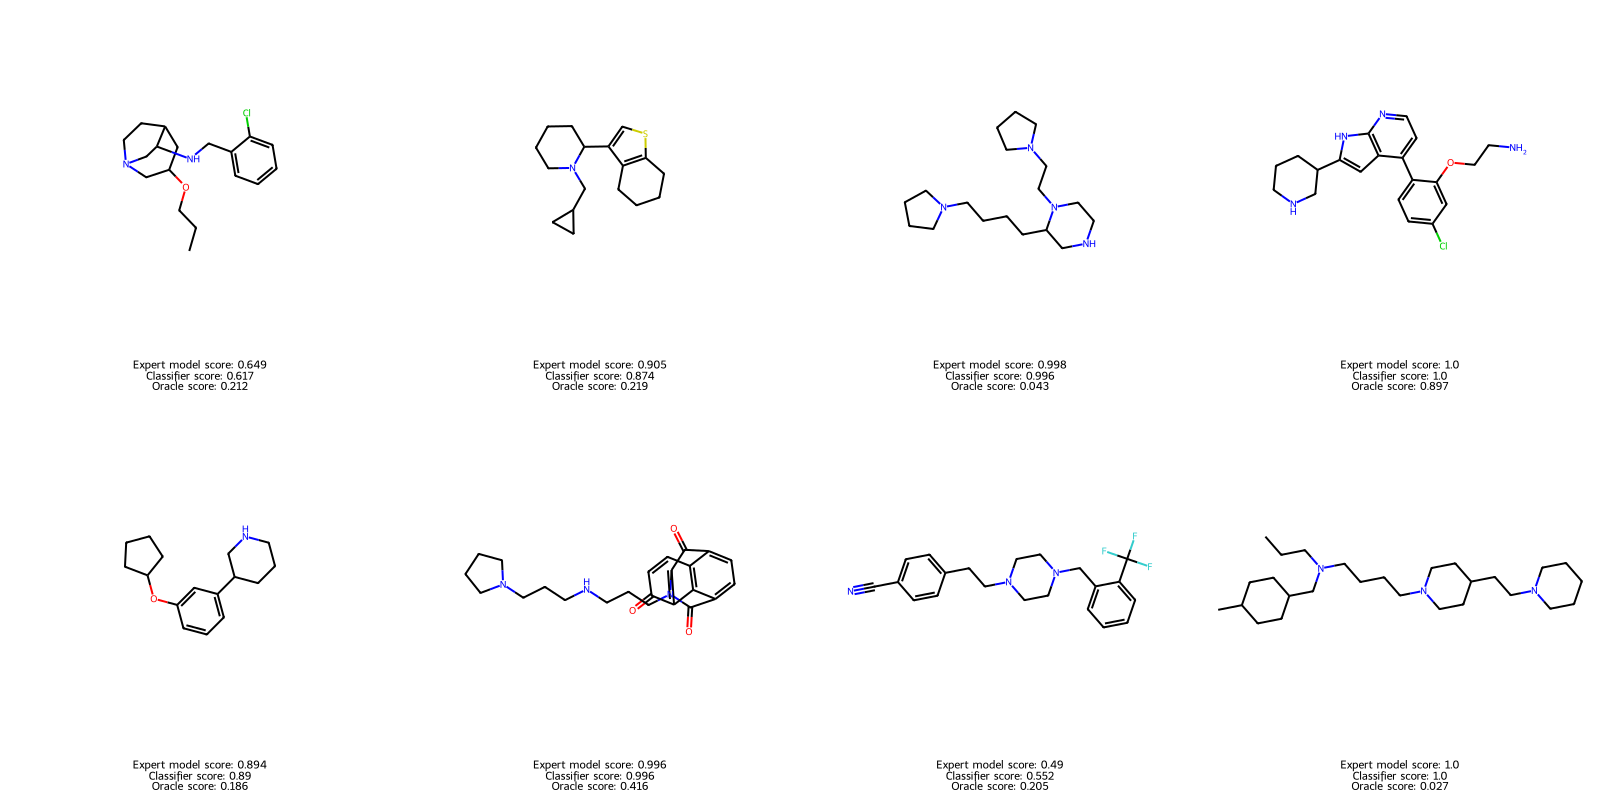

In [65]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# Create a list of SMILES strings representing molecules
smiles_list = sample.SMILES.tolist()
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# 2D coordinates for the molecules
for mol in molecule_list:
    AllChem.Compute2DCoords(mol)

grid_rows = 1
grid_columns = 4

# Create a grid of molecules using RDKit's MolToImage function
img = Draw.MolsToGridImage(
    molecule_list,
    molsPerRow=grid_columns,
    subImgSize=(400, 400),  # Adjust the subimage size as needed
    legends=[
        f"Expert model score: {round(h,3)}\nClassifier score: {round(y,3)}\nOracle score: {round(o,3)}" for h,y,o in zip(sample.bioactivity, sample.classifier_score, sample.oracle_score)],  # Add labels below each molecule
)

img

## Bar plots - oracle and predicted scores at end of generation

In [39]:
import pickle

# path to results dictionary
al_pi1_l2d = pickle.load(open("deferral_AL_pi1_top1000.pkl", "rb"))
al_pi1_nol2d = pickle.load(open("classifier_AL_pi1.pkl", "rb"))

In [75]:
#n_seeds = 5
#for i in range(1,n_seeds+1):
#    plt.plot(np.arange(6), al_pi1_l2d["without_active_learning"]['mean_oracle_scores_top1000'][i], color = "black")
#    plt.plot(np.arange(6), al_pi1_l2d["with_active_learning"]['mean_oracle_scores_top1000']["greedy"][i], color = "blue")
#    plt.plot(np.arange(6), al_pi1_l2d["with_active_learning"]['mean_oracle_scores_top1000']["epig"][i], color = "blue")
#    plt.plot(np.arange(6), al_pi1_l2d["with_active_learning"]['mean_oracle_scores_top1000']["random"][i], color = "blue")
#    plt.plot(np.arange(6), al_pi1_l2d["with_active_learning"]['mean_oracle_scores_top1000']["uncertainty"][i], color = "blue")

In [76]:
#n_seeds = 5
#for i in range(1,n_seeds+1):
#    plt.plot(np.arange(6), al_pi1_nol2d["without_active_learning"]['mean_oracle_scores_top1000'][i], color = "black")
#    plt.plot(np.arange(6), al_pi1_nol2d["with_active_learning"]['mean_oracle_scores_top1000']["greedy"][1], color = "red")
#    plt.plot(np.arange(6), al_pi1_nol2d["with_active_learning"]['mean_oracle_scores_top1000']["epig"][1], color = "red")
#    plt.plot(np.arange(6), al_pi1_nol2d["with_active_learning"]['mean_oracle_scores_top1000']["random"][1], color = "red")
#    plt.plot(np.arange(6), al_pi1_nol2d["with_active_learning"]['mean_oracle_scores_top1000']["uncertainty"][1], color = "red")

In [49]:
n_seeds = 5
acquisition_methods = ["greedy", "epig", "uncertainty", "random"]

final_oracle_score_nol2d, final_pred_score_nol2d = [], []
final_oracle_score_l2d, final_pred_score_l2d = [], []
final_oracle_score_nol2d_noAL, final_pred_score_nol2d_noAL = [], []
final_oracle_score_l2d_noAL, final_pred_score_l2d_noAL = [], []

for acquisition in acquisition_methods:

    for i in range(1,n_seeds+1):
        
        #get oracle and predicted scores computed on top 1000 generated molecules (with AL)
        final_oracle_score_nol2d.append(
            al_pi1_nol2d["with_active_learning"]['mean_oracle_scores_top1000'][acquisition][i][-1] # -1: last round of generation
        )
        final_pred_score_nol2d.append(
            al_pi1_nol2d["with_active_learning"]['mean_predicted_scores_top1000'][acquisition][i][-1]
            )
    
        final_oracle_score_l2d.append(
            al_pi1_l2d["with_active_learning"]['mean_oracle_scores_top1000'][acquisition][i][-1]
        )
        final_pred_score_l2d.append(
            al_pi1_l2d["with_active_learning"]['mean_predicted_scores_top1000'][acquisition][i][-1]
        )
    
        #get oracle and predicted scores computed on top 1000 generated molecules (without AL)
        final_oracle_score_nol2d_noAL.append(
            al_pi1_nol2d["without_active_learning"]['mean_oracle_scores_top1000'][i][-1]
        )
        final_pred_score_nol2d_noAL.append(
            al_pi1_nol2d["without_active_learning"]['mean_predicted_scores_top1000'][i][-1]
        )
        
        final_oracle_score_l2d_noAL.append(
            al_pi1_l2d["without_active_learning"]['mean_oracle_scores_top1000'][i][-1]
        )
        
        final_pred_score_l2d_noAL.append(
            al_pi1_l2d["without_active_learning"]['mean_predicted_scores_top1000'][i][-1]
        )

TypeError: __init__() got an unexpected keyword argument 'ncols'

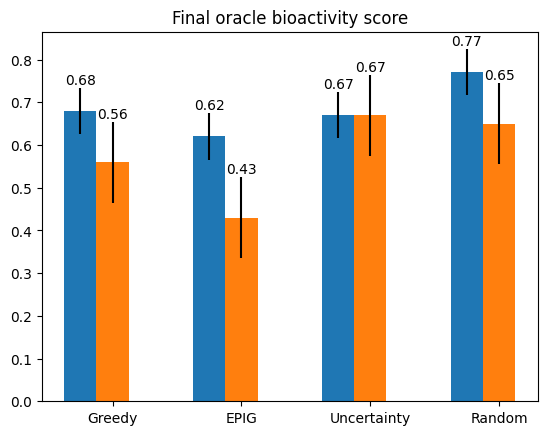

In [73]:
strategies = ("Greedy", "EPIG", "Uncertainty", "Random")
means = {
    'L2D': [
        round(np.mean(results),2) for results in [
            final_oracle_score_l2d[i:i+n_seeds] for i in range(0, len(final_oracle_score_l2d), n_seeds)]
    ],
    'No L2D': [
        round(np.mean(results),2) for results in [
            final_oracle_score_nol2d[i:i+n_seeds] for i in range(0, len(final_oracle_score_nol2d), n_seeds)]
    ]
}

std = {
    key: np.std(values) for key, values in means.items()
}

x = np.arange(len(strategies)) 
width = 0.25
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=[std[attribute] for _ in measurement])
    ax.bar_label(rects, padding=0.5)
    multiplier += 1


ax.set_title('Final oracle bioactivity score')
ax.set_xticks(x + width, strategies)
ax.legend(loc='upper left', ncols=3)

plt.show()

TypeError: __init__() got an unexpected keyword argument 'ncols'

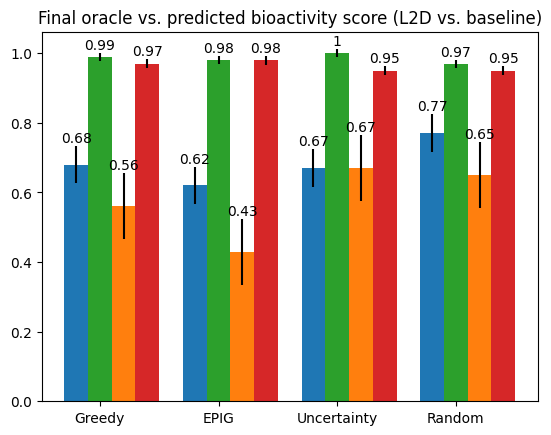

In [74]:
strategies = ("Greedy", "EPIG", "Uncertainty", "Random")
means = {
    'L2D Oracle AL': [
        round(np.mean(results),2) for results in [
            final_oracle_score_l2d[i:i+n_seeds] for i in range(0, len(final_oracle_score_l2d), n_seeds)]
    ],
    'L2D Predicted AL': [
        round(np.mean(results),2) for results in [
            final_pred_score_l2d[i:i+n_seeds] for i in range(0, len(final_pred_score_l2d), n_seeds)]
    ],
    'No L2D Oracle AL': [
        round(np.mean(results),2) for results in [
            final_oracle_score_nol2d[i:i+n_seeds] for i in range(0, len(final_oracle_score_nol2d), n_seeds)]
    ],
    'No L2D Predicted AL': [
        round(np.mean(results),2) for results in [
            final_pred_score_nol2d[i:i+n_seeds] for i in range(0, len(final_pred_score_nol2d), n_seeds)]
    ]
    
}

x = np.arange(len(strategies)) 
width = 0.20
multiplier = 0

std = {
    key: np.std(values) for key, values in means.items()
}

colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

fig, ax = plt.subplots()

for idx, (attribute, measurement) in enumerate(means.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=[std[attribute] for _ in measurement], color=colors[idx])
    ax.bar_label(rects, padding=0.5)
    multiplier += 1

ax.set_title('Final oracle vs. predicted bioactivity score (L2D vs. baseline)')
ax.set_xticks(x + width, strategies)
ax.legend(loc='upper left', ncols=3)

plt.show()